In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 

# Tiền xử lý dữ liệu Amazon Sale Dataset

Các thuộc tính: Quantity, UnitPrice, Discount, Tax, ShippingCost, Category, Brand, PaymentMethod, OrderStatus, OrderDate, Country

In [38]:
# Đọc dữ liệu
df = pd.read_csv('Amazon_SaleData.csv')

# Chọn các cột cần thiết
columns_to_keep = ['Quantity', 'UnitPrice', 'Discount', 'Tax', 'ShippingCost', 
                   'Category', 'Brand', 'PaymentMethod', 'OrderStatus', 
                   'OrderDate', 'Country']
df = df[columns_to_keep]

df.head()

,Quantity,UnitPrice,Discount,Tax,ShippingCost,Category,Brand,PaymentMethod,OrderStatus,OrderDate,Country
0,3,106.59,0.00,0.00,0.09,Books,BrightLux,Debit Card,Delivered,2023-01-31,India
1,1,251.37,0.05,19.10,1.74,Home & Kitchen,UrbanStyle,Amazon Pay,Delivered,2023-12-30,United States
2,3,35.03,0.10,7.57,5.91,Clothing,UrbanStyle,Debit Card,Delivered,2022-05-10,United States
3,5,33.58,0.15,11.42,5.53,Home & Kitchen,Zenith,Cash on Delivery,Delivered,2023-07-18,India
4,2,515.64,0.25,38.67,9.23,Clothing,KiddoFun,Credit Card,Cancelled,2023-02-04,Canada


## Khám phá dữ liệu ban đầu

In [39]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Quantity       100000 non-null  int64  
 1   UnitPrice      100000 non-null  float64
 2   Discount       100000 non-null  float64
 3   Tax            100000 non-null  float64
 4   ShippingCost   100000 non-null  float64
 5   Category       100000 non-null  object 
 6   Brand          100000 non-null  object 
 7   PaymentMethod  100000 non-null  object 
 8   OrderStatus    100000 non-null  object 
 9   OrderDate      100000 non-null  object 
 10  Country        100000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 8.4+ MB


,Quantity,UnitPrice,Discount,Tax,ShippingCost
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.001400,302.905748,0.074226,68.468902,7.406660
std,1.413548,171.840797,0.082583,74.131180,4.324057
min,1.000000,5.000000,0.000000,0.000000,0.000000
25%,2.000000,154.190000,0.000000,15.920000,3.680000
50%,3.000000,303.070000,0.050000,45.250000,7.300000
75%,4.000000,451.500000,0.100000,96.060000,11.150000
max,5.000000,599.990000,0.300000,538.460000,15.000000


## Xử lý dữ liệu trùng lặp

In [40]:
duplicate_count = df.duplicated().sum()
if duplicate_count > 0:
    df = df.drop_duplicates()

## Xử lý giá trị thiếu

In [41]:
# Lưu bản sao
df_backup = df.copy()

# Kiểm tra giá trị thiếu
missing_values = df.isnull().sum()
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': (missing_values / len(df)) * 100
})
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

,Missing Count,Percentage


### Điền khuyết cho cột số (dùng median)

In [42]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

### Điền khuyết cho cột phân loại (dùng mode)

In [43]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_columns:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        df[col].fillna(mode_value, inplace=True)

## Chuẩn hóa kiểu dữ liệu và làm sạch dữ liệu phân loại

In [44]:
# Chuyển đổi OrderDate sang datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

# Làm sạch cột phân loại
categorical_cols = ['Category', 'Brand', 'PaymentMethod', 'OrderStatus', 'Country']

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].str.replace(r'\s+', ' ', regex=True)
        df[col] = df[col].str.title()

## Kiểm tra giá trị không hợp lệ

In [45]:
# Kiểm tra và xử lý giá trị không hợp lệ
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] >= 0]

# Chuẩn hóa Discount về 0-1 nếu cần
if df['Discount'].max() > 1:
    df['Discount'] = df['Discount'] / 100

df = df[(df['Discount'] >= 0) & (df['Discount'] <= 1)]
df = df[df['Tax'] >= 0]
df = df[df['ShippingCost'] >= 0]

## Phát hiện outliers (IQR method)

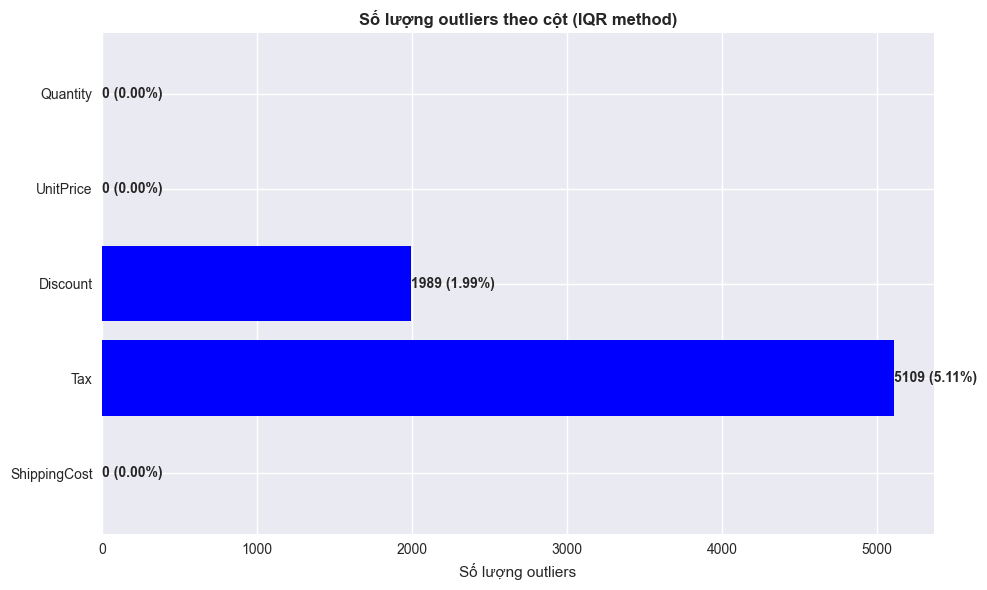

,Column,Lower Bound,Upper Bound,Outliers,Percentage
0,Quantity,-1.000,7.000,0,0.000
1,UnitPrice,-291.775,897.465,0,0.000
2,Discount,-0.150,0.250,1989,1.989
3,Tax,-104.290,216.270,5109,5.109
4,ShippingCost,-7.525,22.355,0,0.000


In [49]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

numeric_cols = ['Quantity', 'UnitPrice', 'Discount', 'Tax', 'ShippingCost']
outlier_summary = []
for col in numeric_cols:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    outlier_summary.append({
        'Column': col,
        'Lower Bound': lower,
        'Upper Bound': upper,
        'Outliers': len(outliers),
        'Percentage': len(outliers) / len(df) * 100
    })

outlier_df = pd.DataFrame(outlier_summary)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(outlier_df['Column'], outlier_df['Outliers'], color='blue')
ax.set_title('Số lượng outliers theo cột (IQR method)', fontweight='bold')
ax.set_xlabel('Số lượng outliers')
ax.invert_yaxis()
for i, v in enumerate(outlier_df['Outliers']):
    ax.text(v, i, f'{v} ({outlier_df.iloc[i]["Percentage"]:.2f}%)', 
            va='center', fontweight='bold')
plt.tight_layout()
plt.show()

outlier_df

## Tổng kết và lưu dữ liệu

In [47]:
summary = {
    'Shape ban đầu': df_backup.shape,
    'Shape sau khi làm sạch': df.shape,
    'Số dòng đã xóa': len(df_backup) - len(df),
    'Giá trị thiếu': df.isnull().sum().sum(),
    'Dữ liệu trùng lặp': df.duplicated().sum()
}
pd.Series(summary)

Shape ban đầu             (100000, 11)
Shape sau khi làm sạch    (100000, 11)
Số dòng đã xóa                       0
Giá trị thiếu                        0
Dữ liệu trùng lặp                    0
dtype: object

## Tổng kết

### So sánh dataset gốc và đã xử lý

| Tiêu chí | Dataset gốc | Dataset đã xử lý |
|---------|-------------|------------------|
| Số cột | 20 | 11 |
| Số dòng | 100,000 | 100,000 |
| Giá trị thiếu | 0 | 0 |
| Dữ liệu trùng lặp | 0 | 0 |
| Kiểu dữ liệu | Hỗn hợp | Đã chuẩn hóa |

**Các cột đã loại bỏ**: OrderID, CustomerID, CustomerName, ProductID, ProductName, City, SellerID, TotalAmount, State

### Kỹ thuật sử dụng

1. **Lựa chọn thuộc tính**: Giữ lại 11 thuộc tính quan trọng
2. **Xử lý trùng lặp**: `drop_duplicates()`
3. **Xử lý giá trị thiếu**: 
   - Cột số: Điền bằng `median()`
   - Cột phân loại: Điền bằng `mode()`
4. **Chuẩn hóa dữ liệu**:
   - OrderDate: `pd.to_datetime()`
   - Cột phân loại: `str.strip()`, `str.title()`
5. **Kiểm tra giá trị không hợp lệ**: Lọc theo điều kiện (Quantity > 0, Discount [0,1], v.v.)
6. **Phát hiện outliers**: Phương pháp IQR (Interquartile Range)

In [48]:
# Lưu dữ liệu đã làm sạch
output_filename = 'Amazon_SaleData_Cleaned.csv'
df.to_csv(output_filename, index=False)
df.head()

,Quantity,UnitPrice,Discount,Tax,ShippingCost,Category,Brand,PaymentMethod,OrderStatus,OrderDate,Country
0,3,106.59,0.00,0.00,0.09,Books,Brightlux,Debit Card,Delivered,2023-01-31,India
1,1,251.37,0.05,19.10,1.74,Home & Kitchen,Urbanstyle,Amazon Pay,Delivered,2023-12-30,United States
2,3,35.03,0.10,7.57,5.91,Clothing,Urbanstyle,Debit Card,Delivered,2022-05-10,United States
3,5,33.58,0.15,11.42,5.53,Home & Kitchen,Zenith,Cash On Delivery,Delivered,2023-07-18,India
4,2,515.64,0.25,38.67,9.23,Clothing,Kiddofun,Credit Card,Cancelled,2023-02-04,Canada
